In [16]:
#Importing all the necessary libs
import warnings
warnings.filterwarnings("ignore")

import numpy as np   
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
import datetime

# To build sklearn model
from sklearn.linear_model import LogisticRegression

# To get diferent metric scores
from sklearn import metrics
from sklearn.metrics import f1_score,accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils      import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

ModuleNotFoundError: No module named 'sklearn'

# 1. Reading Dataset and Feature Elimination

In [17]:
data_raw = pd.read_csv("data/churn.csv") ## load the given dataset
data = data_raw.copy() # copy the data to new dataframe for the eda purpose
data.shape # find the shape of the dataset

(10000, 14)

In [18]:
data.describe().T # get the stats of teh data

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


**Observations**:

* Dataset has 10000 rows and 14 columns, and the data is non null dataset. 
* Balance & Estimated Salary seems to be right skewed, with max value is extreme right
* There are 2932 unique Surnames and Smith Surname is max with 32 occrence. Surname is not an important in this modeling. so will remove the surname
* Dataset consists of the customer from 3 countries, with France holding 50% of total customers, followed by Germany and Spain roughly 25% of population each
* Bank has more male customers compared to female. 

In [19]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True) 
data['IsActiveMember'] = data['IsActiveMember'].astype('category')
data['HasCrCard'] = data['HasCrCard'].astype('category')
#data['Exited'] = data['Exited'].astype('category')
cat_columns=data.select_dtypes(include=["object", "category"]).columns.tolist()
num_column=data.select_dtypes(include=np.number).columns.tolist()

In [20]:
for objCols in cat_columns:
    tot_count = data[objCols].count().sum()
    print("******",objCols,"******")
    for i,v in data[objCols].value_counts().items():
         print(i,"has ",v," rows, that makes",round((v/tot_count)*100,2) ,"% of total dataset")
    print('*'*100)

****** Geography ******
France has  5014  rows, that makes 50.14 % of total dataset
Germany has  2509  rows, that makes 25.09 % of total dataset
Spain has  2477  rows, that makes 24.77 % of total dataset
****************************************************************************************************
****** Gender ******
Male has  5457  rows, that makes 54.57 % of total dataset
Female has  4543  rows, that makes 45.43 % of total dataset
****************************************************************************************************
****** HasCrCard ******
1 has  7055  rows, that makes 70.55 % of total dataset
0 has  2945  rows, that makes 29.45 % of total dataset
****************************************************************************************************
****** IsActiveMember ******
1 has  5151  rows, that makes 51.51 % of total dataset
0 has  4849  rows, that makes 48.49 % of total dataset
*********************************************************************************

# 2. Exploratory Data Analysis

In [21]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=True, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=True, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

## 2.1 Univariate Analysis - Continuous Variable

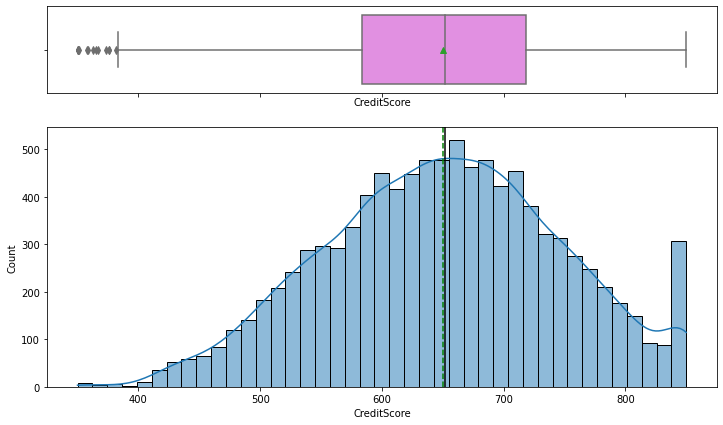

In [22]:
histogram_boxplot(data, 'CreditScore')

**Observation**
* Slight left skwed with more customers having having higher credit scores.

In [ ]:
histogram_boxplot(data, 'Age')

**Observations**
* Most of the customers are in the age group of 30-40 
* The boxplot is right skewed, with the outliers at the extreme end. 
* We shall check on these outliers later section

In [ ]:
histogram_boxplot(data, 'Tenure')

**Observations**
* The Tenure data is evenly distributed. 
* There is no direct correlation inferred here. 

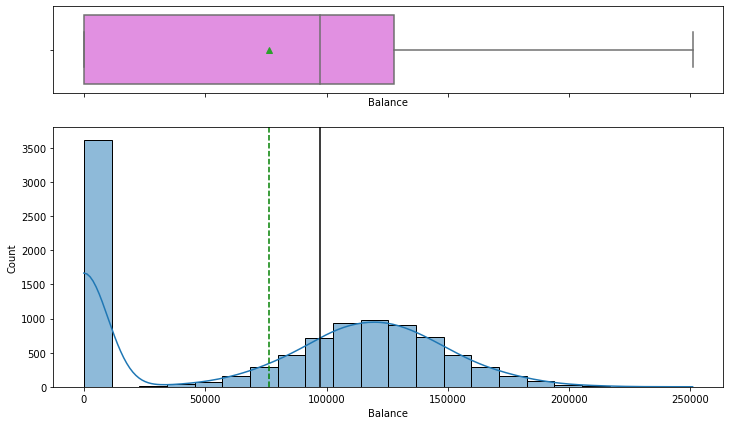

In [23]:
histogram_boxplot(data, 'Balance')

**Observations**
* Balance may be give some insight. 
* Around 35% of the customers have balance 0 or less than 1000. Checking these customers may give some relations. 

In [ ]:
histogram_boxplot(data, 'EstimatedSalary')

**Observations**
* Data is evenly distributed and not much can be inferred here. 

## 2.2 Univariate Analysis - Categorical Variable

In [ ]:
title=['NumOfProducts','IsActiveMember',
       'HasCrCard','Geography',
       'Gender','Exited']

cols = data[
    [
        "NumOfProducts",
        "IsActiveMember",
        "HasCrCard",
        "Geography",
        "Gender","Exited"
    ]
].columns.tolist()
plt.figure(figsize=(14, 20))

for i, variable in enumerate(cols):
    plt.subplot(5, 2, i + 1)
    order = data[variable].value_counts(ascending=False).index   
    ax=sns.countplot(data[variable],palette='Accent')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/len(data[variable]))
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plt.annotate(percentage, (x, y),ha='center')
    plt.tight_layout()
    plt.title(title[i].upper())
plt.show()

**Observations**

**Number of Products**: Most of the customers host atleast one or two products. Very few customers hold 3 or 4 products. 

**IsActive**: Almost only half of the customers are Active with the bank making the transaction. 

**HasCrCard**: Two third of the customers have credit cards. 

**Geography**: Half of the customers are from France and remaining half is from Spain and Germany. 

**Gender**: More customers are male customers with 55 pct compared to female customers. 

**Exited**: 20 pct of the customers has left the bank. and 80pct are still in active member with the bank.

## 2.3 Bivariate Analysis

In [ ]:
sns.pairplot(data[data.select_dtypes('number').columns])
plt.show()

### 2.3.1 Correaltion Matrix

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations**
* Age has the highest relation with the target variable. Since the relationship is positive we can say that as the age of the customer increases, the rate of losing the customer also increases. 
* Exited and Number of Products has highest negative correlation. 
* Exited and Balance has positive relation. 

## 2.3.2 Bivariate Analysis - Churn Vs Numerical Columns


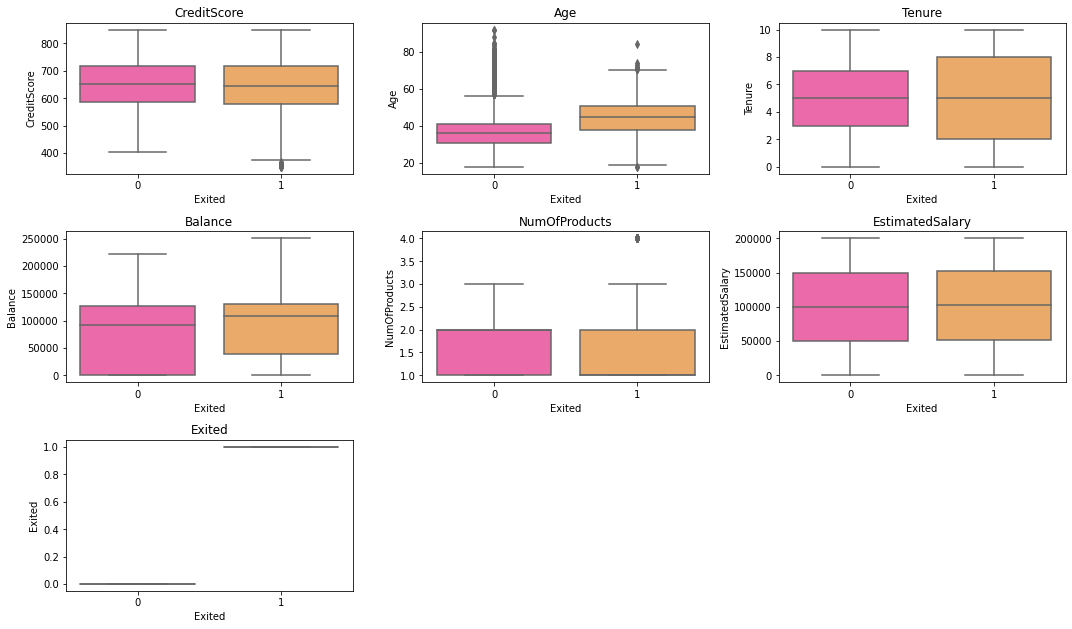

In [24]:
plt.figure(figsize=(15, 20))

for i, variable in enumerate(num_column):
    plt.subplot(7, 3, i + 1)
    sns.boxplot(data["Exited"], data[variable], palette="spring")
    plt.tight_layout()
    plt.title(variable)
plt.show()

## 2.3.3 Bivariate Analysis - Churn Vs Categorical Columns

In [ ]:
title=['Exited vs Geography','Exited vs Gender','Exited vs Has Credit Card',
       'Exited vs ActiveMember']
cols = data.select_dtypes(include=["object", "category"]).columns.tolist()

plt.figure(figsize=(14, 20))

for i, variable in enumerate(cols):
    plt.subplot(6, 2, i + 1)
    ax=sns.countplot(data[variable],hue=data["Exited"],palette='Pastel1')
    ax.set_ylabel('')
    bars = ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]

    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r

        ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
        ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")
    plt.tight_layout()
    plt.title(title[i])
plt.show()

**Observations**
* Germany has more bank customer left the bank compared to France and Spain
* Female customers are more likely to leave the bank compared to male. 
* Inactive customers leave the bank faster than active one
* Customer having a credit card has left the bank a lot to the one doesnt have

## 2.4 Multivariate Analysis 

In [ ]:
plt.figure(figsize=(10,4))
sns.distplot(data[data["Exited"] == 0]['Age'], color = 'g',label='Existing Customer')
sns.distplot(data[data["Exited"] == 1]['Age'], color = 'm',label='Attrited Customer')
plt.legend()
plt.title("Income Distribution")

## 2.4.1 Multivariate Analysis - NumOfProducts vs Numerical Data vs Churn

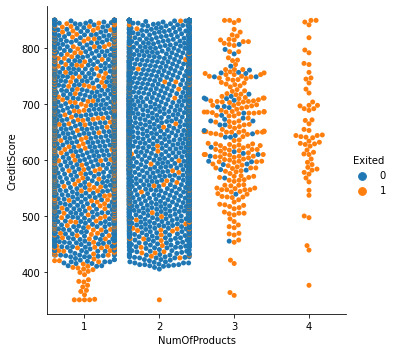

In [8]:
sns.catplot(x='NumOfProducts', y='CreditScore', hue='Exited', data = data, kind='swarm')

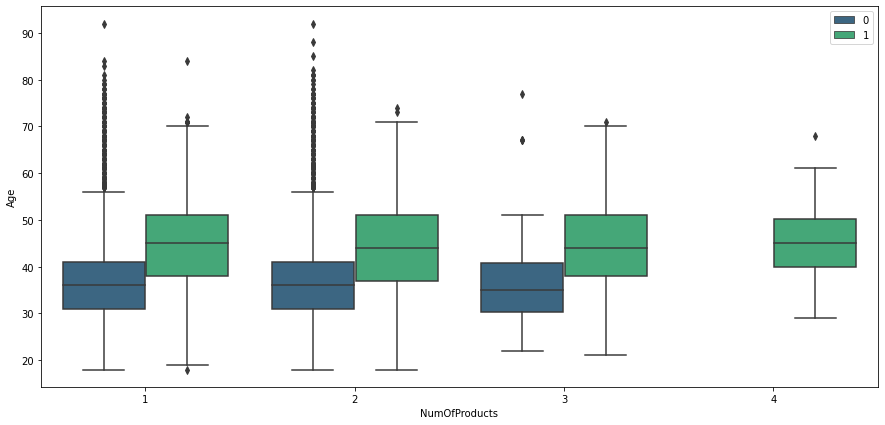

In [9]:
plt.figure(figsize=(15,7))
sns.boxplot(data["NumOfProducts"],data["Age"],hue=data["Exited"],palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

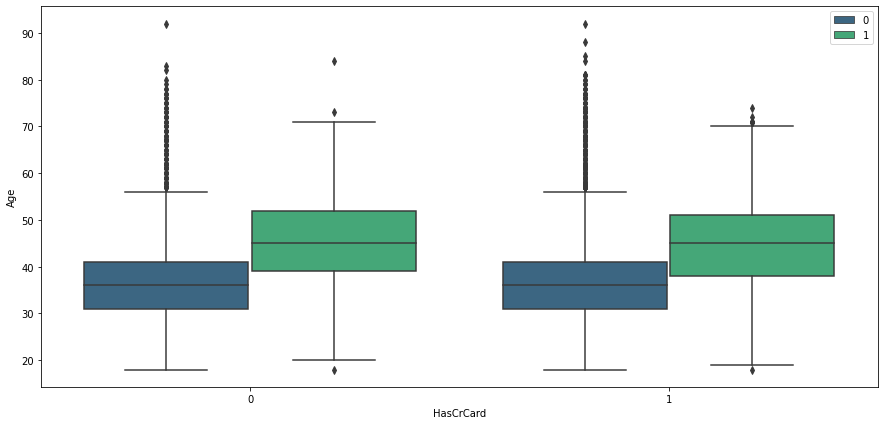

In [10]:
plt.figure(figsize=(15,7))
sns.boxplot(data["HasCrCard"],data["Age"],hue=data["Exited"],palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

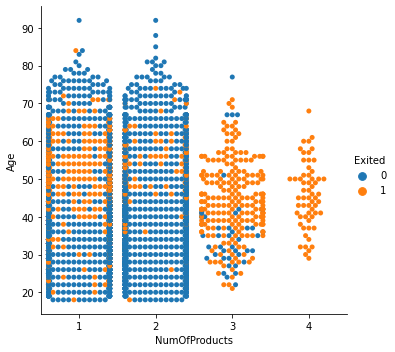

In [11]:
sns.catplot(x='NumOfProducts', y='Age', hue='Exited', data = data, kind='swarm')

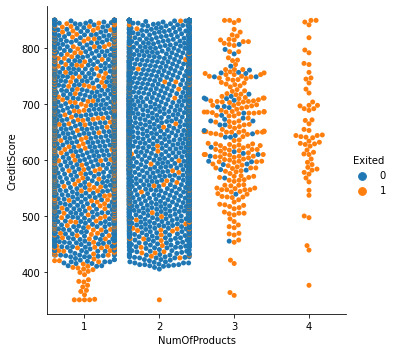

In [12]:
sns.catplot(x='NumOfProducts', y='CreditScore', hue='Exited', data = data, kind='swarm')

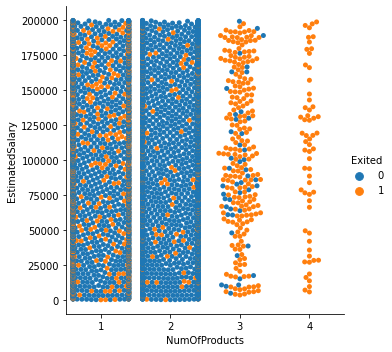

In [13]:
sns.catplot(x='NumOfProducts', y='EstimatedSalary', hue='Exited', data = data, kind='swarm')

## 2.4.2 Multivariate Analysis - Geography vs Numerical Data vs Churn


In [ ]:
sns.catplot(x='Geography', y='Age', hue='Exited', data = data, kind='swarm')

In [ ]:
sns.catplot(x='Geography', y='CreditScore', hue='Exited', data = data, kind='swarm')

In [ ]:
fig=plt.figure(figsize=(7,5))
# Then, for each country we will find all the men
Men = [data.loc[(data['Geography']=='France') & (data['Gender']=='Male'), 'Balance'].sum()/10**6, 
       data.loc[(data['Geography']=='Germany') & (data['Gender']=='Male'), 'Balance'].sum()/10**6,
       data.loc[(data['Geography']=='Spain') & (data['Gender']=='Male'), 'Balance'].sum()/10**6]

# To find the women, we subtract men from total amount of customers
Women = [data.loc[(data['Geography']=='France') & (data['Gender']=='Female'), 'Balance'].sum()/10**6, 
       data.loc[(data['Geography']=='Germany') & (data['Gender']=='Female'), 'Balance'].sum()/10**6,
       data.loc[(data['Geography']=='Spain') & (data['Gender']=='Female'), 'Balance'].sum()/10**6]
# Contribution Ratio

CRatio = [Women[k]/Men[k] for k in range(len(Men))]

# Let's define the width of each bar
barWidth = 0.3

# The x position of bars
r1 = np.arange(len(Men))
r2 = [x + barWidth for x in r1]
 
# Plot men per country
plt.bar(r1, Men, width = barWidth, color = '#5539cc', edgecolor = 'black', label='Men')
# Plot women per country
plt.bar(r2, Women, width = barWidth, color = '#cb416b', edgecolor = 'black', label='Women')
 
# General layout
plt.xticks([r + barWidth for r in range(len(Men))], ['France\nCRatio: ' + str(round(CRatio[0],2)), 'Germany\nCRatio: ' + str(round(CRatio[1],2)), 'Spain\nCRatio: ' + str(round(CRatio[2],2))],fontsize=12)
plt.ylabel('Million €',fontsize=12)
plt.title('Total Balance by Nation and Gender', fontsize=18)
plt.legend()


# Show graphic
plt.show()

In [ ]:
df_exited= data[data['Exited']==1]

In [ ]:
fig = plt.figure(figsize=[15,6]);
ax=sns.countplot(data=data, x='Geography', hue='HasCrCard',palette='gray')
sns.countplot(data=df_exited, x='Geography', hue='HasCrCard', palette="autumn")
plt.xticks(fontsize=14);
plt.xlabel('Geography', fontsize=14, fontweight='bold');
plt.yticks(fontsize=14);
plt.ylabel('Count', fontsize=14, fontweight='bold');
plt.legend(fontsize=12, bbox_to_anchor=(0.5,1));
plt.title('Non Churn(Grey) vs Churn(Red) vs Geography vs HasCrCard', fontsize=16, fontweight='bold');

In [ ]:
fig = plt.figure(figsize=[15,6]);
ax=sns.countplot(data=data, x='HasCrCard', hue='IsActiveMember',palette='gray')
sns.countplot(data=df_exited, x='HasCrCard', hue='IsActiveMember', palette="autumn")
plt.xticks(fontsize=14);
plt.xlabel('HasCrCard', fontsize=14, fontweight='bold');
plt.yticks(fontsize=14);
plt.ylabel('Count', fontsize=14, fontweight='bold');
plt.legend(fontsize=12, bbox_to_anchor=(0.5,1));
plt.title('Non Churn(Grey) vs Churn(Red) vs IsActiveMember vs HasCrCard', fontsize=16, fontweight='bold');

In [ ]:
fig = plt.figure(figsize=[15,6]);
ax=sns.countplot(data=data, x='Geography', hue='NumOfProducts',palette='gray')
sns.countplot(data=df_exited, x='Geography', hue='NumOfProducts', palette="autumn")
plt.xticks(fontsize=14);
plt.xlabel('Geography', fontsize=14, fontweight='bold');
plt.yticks(fontsize=14);
plt.ylabel('Count', fontsize=14, fontweight='bold');
plt.legend(fontsize=12, bbox_to_anchor=(0.5,1));
plt.title('Non Churn(Grey) vs Churn(Red) vs Geography vs NumOfProducts', fontsize=16, fontweight='bold');

#  2.5 <a id='link1'>Summary of EDA</a>  
**Data Description:**

- There are no duplicates observed in the dataset.
- There are no missing values but outliers in the data, which will be handled in the feature engineering section
- Dataset contains 10000 rows and 14 columns
- Columns are in mixed datatype int, float and category.
- Customer ID, RowNum and SurName columns is not needed for futher analysis and hence dropped at the earlier stage
- Age, CreditScore, Balance, EstimatedSalary are continuous variables.



**Observations from EDA:**

* Most of the customers are from France. However the customers from Germany are the one tend to leave the bank more than other countries. 
* In total, female customers left the bank compared to the male customer. 
* Customer who hold the credit card has some impact to leaving the bank
* Inactive customers seem to leave the bank.  
* Credit score doesnt give much insight.
* Younger customers are retained with the bank, while the older customer leave the bank.
* The clients on the both ends of the tenure leave the bank. Means those who spent little time with bank or more time with the bank. 
* Balance data shows that bank looses the customers across the balance range. There are customers who left the bank with zero balance and there are few left having more balance amount.
* Customers having 3 or 4 products with the bank has seen leaving the bank.
* There is no salary gap between Male and female in all the country. 

In general, 

* Gernams are more likely to leave the bank than any other nationality
* Female customer generally leave the bank at the higher rate
* Older customers holding credit card and more product with the bank leave the bank. 


#  3. Data Pre-Processing


### 3.1 Missing Value Treatment

In [ ]:
data.isnull().sum().sort_values(ascending=False).head()

No missing value or null observed in the dataset. Hence no treatment is needed

### 3.2 Outlier Detection

- Let's find outliers in the data using z-score with a threshold of 3.

In [ ]:
threshold = 3
outlier = {}
for col in data.select_dtypes('number'):
    i = data[col]
    mean = np.mean(data[col])
    std = np.std(data[col])
    list1 = []
    for v in i:
        z = (v - mean) / std
        if z > threshold:
            list1.append(v)
    list1.sort()
    outlier[i.name] = list1

print("The following are the outliers in the data:")
for key, value in outlier.items():
    print("\n", key, ":", value)

**Observations**

- There are outliers in the columns *Age* and *NumOfProducts*.
- We will not treat the outliers as most of those outliers are not disjoint from the curve (continues curve).
- These outliers might also form their own cluster.

In [ ]:
def get_metrics_score(model,train,test,train_y,test_y,threshold=0.5,flag=True,roc=False):
    '''
    Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and F1 score
    model: classifier to predict values of X
    train, test: Independent features
    train_y,test_y: Dependent variable
    threshold: thresold for classifiying the observation as 1
    flag: If the flag is set to True then only the print statements showing different will be displayed. The default value is set to True.
    roc: If the roc is set to True then only roc score will be displayed. The default value is set to False.
    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = (model.predict_proba(train)[:,1]>threshold)
    pred_test = (model.predict_proba(test)[:,1]>threshold)

    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    train_f1 = f1_score(train_y,pred_train)
    test_f1 = f1_score(test_y,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
    
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
        print("F1 on training set : ",f1_score(train_y,pred_train))
        print("F1 on test set : ",f1_score(test_y,pred_test))
   
    if roc == True:
        pred_train_prob = model.predict_proba(train)[:,1]
        pred_test_prob = model.predict_proba(test)[:,1]
        print("ROC-AUC Score on training set : ",roc_auc_score(train_y,pred_train))
        print("ROC-AUC Score on test set : ",roc_auc_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [ ]:
def make_confusion_matrix(model,test_X,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    test_X: test set
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(test_X)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[1,0])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - <=50K","Actual - >50K"]],
                  columns = [i for i in ['Predicted - <=50K','Predicted - >50k']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 3.3 Feature Engineering and Scaling


In [ ]:
# Copy the raw data
data_model_1 = data_raw.copy()  

# Eliminating unnecesary attributes
data_model_1.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)  # inplace=True to perform it over the dataset itself

data_model_1.rename(columns = {'Gender':'IsMale'}, inplace=True)
data_model_1.IsMale.loc[data_model_1.IsMale == 'Female'] = 0        # Alternative doesn't work: bank_data.IsMale.replace([0, 1], ['Female', 'Male'], inplace=True)
data_model_1.IsMale.loc[data_model_1.IsMale == 'Male'] = 1
data_model_1['IsMale'] = data_model_1['IsMale'].astype('int')
# Separating numerical (to normalize) and categorical variables (one-hot encoding)
num_subset = data_model_1.select_dtypes('number')
cat_subset = data_model_1.select_dtypes('object')

# Obtain one-hote enconded features using pd.get_dummies
cat_subset = pd.get_dummies(cat_subset)

# We save a denormalized but organized version of the dataset. This will be useful for some figures.
denorm_bank_data = pd.concat([cat_subset, num_subset], axis=1)

# Normalizing numerical variables
maxvals = num_subset.astype(float).max()                      # Finds maximum value
numericalColumns = {'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'}
for col in numericalColumns:
  num_subset[str(col)] = num_subset[str(col)]/maxvals[col]    # Divide each column (variable) by its maximum
data_model_1 = pd.concat([cat_subset, num_subset], axis=1)       # Concatenate both subsets

# Printing dataset types
# uint8: unsigned integer 0-255 (natural), int64: Integer (-9223372036854775808 to 9223372036854775807) float64: Double precision float
print(data_model_1.dtypes)  

# Displaying a dataset head
display(data_model_1.head())

# Defining X and Y
bankX = data_model_1.iloc[:,:12]
bankY = data_model_1.iloc[:,12:13]

In [ ]:
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_score_train=[]
f1_score_test=[]

def make_confusion_matrix1(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""
    
    acc_test.append(accuracy)
    recall_test.append(recall)
    precision_test.append(precision)
    f1_score_test.append(f1_score)
    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## 3.4 Data Preparation for Modelling

In [ ]:
X = data_model_1.drop(['Exited'], axis=1)
y = data_model_1['Exited']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

## 4. Model Building


In [ ]:
models = []  # list that will contain the models i will be using in this project

### 4.1 Model 1: Logistic Regression

In [ ]:
# There are different solvers available in Sklearn logistic regression
# The newton-cg solver is faster for high-dimensional data
lg = LogisticRegression(solver='newton-cg',random_state=1)
lgmodel  = lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)
lg.score(X_test,y_test)
cm1=confusion_matrix(y_test, y_pred)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Non Churn','Churn']
# checking model performances for this model
scores_LR = get_metrics_score(lgmodel,X_train,X_test,y_train,y_test)

# creating confusion matrix
#make_confusion_matrix(lg,X_test,y_test)
make_confusion_matrix1(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues', title='Confusion Matrix of Logistic Regression')
models.append(lgmodel)

### 4.2: Model 2: Random Forrest


In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
rf_model = random_forest.fit(X_train,y_train.values.ravel())    # np.ravel() Return a contiguous flattened array
y_pred = random_forest.predict(X_test)
random_forest.score(X_test,y_test)
cm1=confusion_matrix(y_test, y_pred)
scores_RF = get_metrics_score(rf_model,X_train,X_test,y_train,y_test)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Churn','Churn']
make_confusion_matrix1(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues', title='Confusion Matrix of Random Forest')
models.append(rf_model)

## Model evaluation criterion

### Model can make wrong predictions as:
* Predicting a customer will exit a bank and the customer remains with the bank
* Predicting a customer will not exit the bank but the customer exits

### Which case is more important? 
* Predicting that a customer will not exit the bank but exit the bank. It might enable heavy loss to the bank 

### How to reduce this loss i.e need to reduce False Negative?
* Company  would want `Recall` to be maximized, greater the Recall higher the chances of minimizing false Negative. Hence, the focus should be on increasing Recall or minimizing the false Negative or in other words identifying the True Positive(i.e. Class 1) so that the Company can identify the fraud transaction.

## Let's now explore Neural Network models

## Deep neural network

### 4.3 Model-3 - DNN Base Model

- We will use a simple NN made of 5 fully-connected layers with ReLu activation. The NN takes a vector of length 29 as input. This represents the information related to each transactions, ie each line with 29 columns from the dataset. For each transaction, the final layer will output a probability distribution (sigmoid activation function) and classify either as not fraudulent (0) or fraudulent (1).
- a dropout step is included to prevent overfitting.



**Dropout**

Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly.

### Creating a model

Keras model object can be created with Sequential class

At the outset, the model is empty per se. It is completed by adding additional layers and compilation

### Adding layers [layers and activations]

Keras layers can be added to the model

Adding layers are like stacking lego blocks one by one

It should be noted that as this is a classification problem, sigmoid layer (softmax for multi-class problems) should be added

In [ ]:

origDataModel = []  # will contain the #iterations models trained with the original (imbalanced) data
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test
#X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2)
  # Common X_val and Y_val for validating the classifiers
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2)
  
model = tf.keras.Sequential()

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128,  activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(8,  activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.001),
            loss='binary_crossentropy',
            metrics=['acc'])
models.append(model)
model_logs = model.fit(X_train,
      y_train,
      batch_size=32,
      epochs=150,
      verbose=0,  # silent mode
      validation_data=(X_test, y_test))  # Only to check that the model is not "overfitting" the training data

origDataModel.append(model)

# Pseudo-validate with common validation data

score = model.evaluate(X_test, y_test, verbose=0)  # tensorflow default threshold = 0.5
print("Accuracy training with imbalanced data (default threshold=0.5): {:-5f} %".format(score[1] * 100))

y_pred = model.predict(X_test) > 0.5  # manual threshold
matConf = confusion_matrix(y_test, y_pred)
valsize = y_test.shape[0]

# Capturing learning history per epoch
hist  = pd.DataFrame(model_logs.history)
hist['epoch'] = model_logs.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)
#cm2=confusion_matrix(y_val, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Churn','Churn']
#scores_ann = get_metrics_score(model,X_train,X_test,y_train,y_test)
make_confusion_matrix1(matConf, 
                  group_names=labels,
                  categories=categories, 
                  cmap='Blues',title='Confusion Matrix of ANN Base Model')

Detection of fraudulent transactions did not improve compared to the previous machine learning model ( Randomforest).

- There are 211 customers predicted to exit the bank in the test data and yet 210 Churn customers are not identified (false negative) which remains an issue. Our objective must be to detect as many customer churn as possible since these can have a huge negative impact.

- 210 regular transactions are detected as potentially churn customer by the model. These are false positive. This number is negligible.

**Conclusion:**

We must find ways to further reduce the number of false negative.
##Let's try another architecture to get the better Recall 


There are some basic Hyperparameters which can help to get the better model performance.

**Early stopping:** 

During training, the model is evaluated on a holdout validation dataset after each epoch. If the performance of the model on the validation dataset starts to degrade or no improvement (e.g. loss begins to increase or accuracy begins to decrease), then the training process is stopped after the certian interations.The model at the time that training is stopped is then used and is known to have good generalization performance.

This procedure is called “early stopping” and is perhaps one of the oldest and most widely used forms of neural network regularization.

**Weight Initialization**

Weight initialization is an important consideration in the design of a neural network model.

The nodes in neural networks are composed of parameters referred to as weights used to calculate a weighted sum of the inputs.

Neural network models are fit using an optimization algorithm called stochastic gradient descent that incrementally changes the network weights to minimize a loss function, hopefully resulting in a set of weights for the mode that is capable of making useful predictions.

This optimization algorithm requires a starting point in the space of possible weight values from which to begin the optimization process. Weight initialization is a procedure to set the weights of a neural network to small random values that define the starting point for the optimization (learning or training) of the neural network model.

There are many WI techniques as follows:

1) Random normal initialization

2) Random Uniform initialization

3) Xaviour Initialization

4) He Initialization 

### 4.4: Model 4: Early Stopping


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

  
es= keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=15,

                         verbose=0, mode='min', restore_best_weights= True)
model = Sequential()

model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128,  activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(8,  activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

model.compile(Adam(lr=0.001),
            loss='binary_crossentropy',
            metrics=['acc'])
models.append(model)
model_logs = model.fit(X_train,
      y_train,
      batch_size=32, callbacks=[es],
      epochs=120,
      verbose=0,  # silent mode
      validation_data=(X_test, y_test))  # Only to check that the model is not "overfitting" the training data

origDataModel.append(model)

# Pseudo-validate with common validation data

score = model.evaluate(X_test, y_test, verbose=0)  # tensorflow default threshold = 0.5
print("Accuracy training with imbalanced data (default threshold=0.5): {:-5f} %".format(score[1] * 100))

y_pred = model.predict(X_test) > 0.5  # manual threshold
matConf = confusion_matrix(y_test, y_pred)
valsize = y_test.shape[0]

# Capturing learning history per epoch
hist  = pd.DataFrame(model_logs.history)
hist['epoch'] = model_logs.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)
#cm2=confusion_matrix(y_val, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Churn','Churn']
make_confusion_matrix1(matConf, 
                  group_names=labels,
                  categories=categories, 
                  cmap='Blues', title="Confusion Matrix of Early Stopping")

**Conclusion:**

As you can see here the Recall of the model is not improved and it is worse than the Previous ANN model as well as the RandomForest but the precision is changed.

Let's try weighted loss for imbalance dataset

### 4.5: Model 5:  Weighted loss to account for large class imbalance in train dataset
- we will adjust the class imbalance by giving additional weight to the loss associated to errors made on fraudulent transaction detection.

We will use our first ANN model and apply weighted loss


 Let's review the process:

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y.ravel(), test_size=0.3)
  
es= keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=15,

                         verbose=0, mode='min', restore_best_weights= True)
model = Sequential()

model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128,  activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(8,  activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

model.compile(Adam(lr=0.001),
            loss='binary_crossentropy',
            metrics=['acc'])
models.append(model)
model_logs = model.fit(X_train,
      y_train,
      batch_size=32, class_weight=class_weights,
      epochs=120,
      verbose=0,  # silent mode
      validation_data=(X_test, y_test))  # Only to check that the model is not "overfitting" the training data

origDataModel.append(model)

# Pseudo-validate with common validation data

score = model.evaluate(X_test, y_test, verbose=0)  # tensorflow default threshold = 0.5
print("Accuracy training with imbalanced data (default threshold=0.5): {:-5f} %".format(score[1] * 100))

y_pred = model.predict(X_test) > 0.5  # manual threshold
matConf = confusion_matrix(y_test, y_pred)
valsize = y_test.shape[0]

# Capturing learning history per epoch
hist  = pd.DataFrame(model_logs.history)
hist['epoch'] = model_logs.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)
#cm2=confusion_matrix(y_val, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Churn','Churn']
make_confusion_matrix1(matConf, 
                  group_names=labels,
                  categories=categories, 
                  cmap='Blues')

### 4.6 : Model Performance Improvement - Resampling Technique

The number of samples belonging to the class 'Exited = 1' (2037) is significantly lower than those belonging to the class 'Exited = 0' (7963). In this situation, model training with these data could lead to inaccurate predictions. In order to obtain the same number of instances for both classes, several techniques present in [imbalanced-learn API](https://imbalanced-learn.org/stable/references/index.html#api) have been used, in such a way that we finally choose the best one. These strategies are divided in **oversampling** techniques (create more instances of the minority class), **undersampling** techniques (reduce the number of instances of the majority class), and the combination between **undersampling + oversampling**.

**Undersampling**: *ClusterCentroids*: Equals to **2037** the number of instances of both classes.

**Oversampling**: *SMOTENC*: Equals to **7963** the number of instances of both classes, *ADASYN*: Increases to **8600** the number of instances of the minority class 'Exited = 1'.

**Undersampling** + **Oversampling**: *SMOTEENN*: Decreases to **5047** the number of instances of the majority class 'Exited = 0' and increases to **6701** the number of instances of the minority class 'Exited = 1'.

In [ ]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTENC, ADASYN
from imblearn.combine import SMOTEENN

li = [ClusterCentroids, SMOTENC, ADASYN, SMOTEENN]  # List of resampling techniques
li_names = ["ClusterCentroids", "SMOTENC", "ADASYN", "SMOTEENN"]  # List of their names (with visualization purposes)


cat_index = [0, 1, 2, 4, 9, 10]  # List of categorical features indexes (only used in SMOTENC)


for n, method in enumerate(li):

    if(method==SMOTENC):  # An instance of the resampling technique
      resampler = method(cat_index) 
    else: resampler = method()

    X_resampled, Y_resampled = resampler.fit_resample(X, y.ravel())  # Resampled sets
    Y_resampled = Y_resampled[:, np.newaxis]

    print("After", li_names[n], ": \nX.shape: {}, Y.shape: {}".format(X_resampled.shape, Y_resampled.shape))
    print("{} '0' labels, {} '1' labels".format(sum(Y_resampled==0), sum(Y_resampled==1)))

    # After resampling, we shuffle to avoid data pools with the same label
    # In this way, even more large fluctuations in accuracy value could be avoided

    data_resampled = np.hstack((X_resampled, Y_resampled))
    np.random.shuffle(data_resampled)
    X_resampled = data_resampled[:,:12]
    Y_resampled = data_resampled[:,12:13]

    X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled.ravel(), test_size=0.2)

    # Neural network model

    modelresampled = tf.keras.Sequential()

    modelresampled.add(Dense(256, activation='relu'))
    modelresampled.add(BatchNormalization())
    modelresampled.add(Dropout(0.3))

    modelresampled.add(Dense(128,  activation='relu'))
    modelresampled.add(BatchNormalization())
    modelresampled.add(Dropout(0.3))

    modelresampled.add(Dense(64, activation='relu'))
    modelresampled.add(BatchNormalization())
    modelresampled.add(Dropout(0.3))

    modelresampled.add(Dense(32, activation='relu'))
    modelresampled.add(BatchNormalization())
    modelresampled.add(Dropout(0.3))

    modelresampled.add(Dense(8,  activation='relu'))
    modelresampled.add(BatchNormalization())
    modelresampled.add(Dropout(0.3))

    modelresampled.add(Dense(1, activation='sigmoid'))

    modelresampled.compile(Adam(lr=0.001),
                  loss='binary_crossentropy',
                  metrics=['acc'])

    modelresampled_logs = modelresampled.fit(X_train,
            Y_train,
            batch_size=32,
            epochs=150,
            verbose=0,  # silent mode
            validation_data=(X_test, Y_test))  # Only to check that the model is not "overfitting" the training data

    models.append(modelresampled)

    # Pseudo-validate with common validation data

    score = modelresampled.evaluate(X_test, Y_test, verbose=0)  # tensorflow default threshold = 0.5
    print(score)
    print("Accuracy training with resampled data (default threshold=0.5): {:-5f} %\n".format(score[1] * 100))
    Y_pred = modelresampled.predict(X_test) > 0.5
    matConf = confusion_matrix(Y_test, Y_pred)
    valsize = Y_test.shape[0]
    #plt.figure(figsize=(12, 10))  # Establishing the heatmap size before plotting
    
    # Capturing learning history per epoch
    hist  = pd.DataFrame(modelresampled_logs.history)
    hist['epoch'] = modelresampled_logs.epoch

    # Plotting accuracy at different epochs
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.legend(("train" , "valid") , loc =0)
    
    #plt.title("Confusion Matrix of ", fontsize=20)
    title = "Confusion Martix of "+li_names[n]
    labels = ['True Negative','False Positive','False Negative','True Positive']
    categories = [ 'Not_Churn','Churn']

    make_confusion_matrix1(matConf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues', title=title)
    plt.show()
  

## 5. Model Comparison


In [ ]:
comparison_frame = pd.DataFrame({'Model':['Logistic Regression','Random Forrest','ANN-Base', 'ANN-Early Stopping',
                                          'ANN-Weighted Loss', 'ANN-ClusterCentroids','ANN-SMOTENC','ANN-ADASYN','ANN-SMOTEENN'], 
                                          'Accuracy': acc_test,
                                          'Recall':recall_test,
                                          'Precision':precision_test,
                                          'f1_score':f1_score_test}) 
comparison_frame

* For the given business case, the model should have better accuracy and recall values. from the above table it is clear that ANN-SMOTE with Edited Nearest Neighbours(SMOTEENN) model gives better accuracy, recall, precision and F1-score. The model looks more generalised one having all the meterics in the same range. 
* The same can be verified in the ROC charts of each models. 

## 6. ROC of all the models

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
li_names = ['Logistic','RandomForest','ANN','Early Stopping','Weighted-ANN',"ClusterCentroids", "SMOTENC", "ADASYN", "SMOTEENN"]
iterations=1
for i in range(iterations):

  plt.figure(i+1, figsize=(11, 11))
  plt.title('ROC Curve for all the models ', fontsize=20)
  plt.xlabel('False positive rate', fontsize=15)
  plt.ylabel('True positive rate', fontsize=15)
  plt.plot([0, 1], [0, 1], '--', color='black')

  for j in range(len(li_names)):  # For each model, calculate false positive rate, true positive rate and area under curve
    pred = models[len(li_names)*i+j].predict(X_test).ravel()  # Predictions for each model
    fpr, tpr, thresholds = roc_curve(Y_test, pred)  # False positive rate, true positive rate, threshold
    auc_ = auc(fpr, tpr)

    opt_index = np.argmax(np.abs(tpr-fpr))  # Optimal threshold: point where tpr is high and fpr is low
    opt_threshold = thresholds[opt_index]
    
    plt.plot(fpr, tpr, label=li_names[j]+' (AUC = {:.5f}, optimal threshold = {:.5f})'.format(auc_, opt_threshold))
    
  plt.legend(loc='lower right', prop={'size': 14})  # Display the legend
  plt.show()

The above ROC curve hints that the most suitable model is the resampled SMOTEENN(Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours) technique, which stands out from the other model results. Due to high accuracy and area under curve(98%) this model outperformed the models trained with original, imbalance data. ROC curve also helped to find the optimal threshold(.54) value of each model. 

To sum up, the results have indicated taht for the give dataset, it is suitable to perform Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours to balance the classes and train the model. 

# 7. Final - Recommendations :

* The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups
* With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.
* The bank is losing customers with significant bank balances which is likely to hit their available capital for lending.
* Bank should focus on the Germany market to understand why the customers from the germany churn more than its neighbouring countries
* Female tend to churn more ,even though the pay gap is not that much between male and female. 
* Customers holding more than 2 products churn at higher rate, Bank should identify the products those customer holding and strategies accordingly. Since there is not much of product details, with the given data set this couldnt be find out. 
